# Day 10: Train on a simple Gaussian

In [44]:
import numpy as np
real_np = np.random.normal(loc=0.0, scale=1.0, size=(10_000, 1))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [45]:
import torch 
from torch.utils.data import TensorDataset, DataLoader

real_tensor = torch.from_numpy(real_np).float()
dataset = TensorDataset(real_tensor)
loader = DataLoader(dataset,batch_size=16,shuffle=True,drop_last=True)

In [46]:
import torch.nn as nn
import torch.optim as optim

latent_dim = 100
hidden_dim = 32
data_dim = 1
batch_size = 16
lr = 2e-4

In [47]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
            
            nn.Linear(latent_dim, hidden_dim),
            nn.ReLU(inplace=True),
            
            nn.Linear(hidden_dim, data_dim)
        )
    def forward(self,z):
        return self.model(z)

In [48]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.model = nn.Sequential(
           
            nn.Linear(data_dim, hidden_dim),
            nn.LeakyReLU(0.2, inplace=True),
            
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )
    def forward(self,x):
        return self.model(x);

In [49]:
G = Generator()
D = Discriminator()
criterion = nn.BCELoss()
opt_G = optim.Adam(G.parameters(), lr=2e-4)
opt_D = optim.Adam(D.parameters(), lr=2e-4)

In [50]:


num_steps   = 2000
print_every = 100

step = 0
while step < num_steps:
    for (real_batch,) in loader:
        if step >= num_steps:
            break

        bsz = real_batch.size(0)
        real_labels = torch.ones(bsz, 1)
        fake_labels = torch.zeros(bsz, 1)

       
        D.zero_grad()
       
        out_real = D(real_batch)
        loss_real = criterion(out_real, real_labels)
        
        z         = torch.randn(bsz, latent_dim)
        fake_det  = G(z).detach()              
        out_fake  = D(fake_det)
        loss_fake = criterion(out_fake, fake_labels)

        loss_D = loss_real + loss_fake
        loss_D.backward()
        opt_D.step()

       
        G.zero_grad()
        z      = torch.randn(bsz, latent_dim)
        fake   = G(z)
        out_Df = D(fake)
        
        loss_G = criterion(out_Df, real_labels)
        loss_G.backward()
        opt_G.step()

       
        if step % print_every == 0:
            print(f"Step {step}/{num_steps}  D-loss: {loss_D.item():.3f}  G-loss: {loss_G.item():.3f}")
        step += 1


Step 0/2000  D-loss: 1.450  G-loss: 0.853
Step 100/2000  D-loss: 1.427  G-loss: 0.730
Step 200/2000  D-loss: 1.411  G-loss: 0.723
Step 300/2000  D-loss: 1.376  G-loss: 0.745
Step 400/2000  D-loss: 1.374  G-loss: 0.743
Step 500/2000  D-loss: 1.286  G-loss: 0.717
Step 600/2000  D-loss: 1.303  G-loss: 0.719
Step 700/2000  D-loss: 1.321  G-loss: 0.716
Step 800/2000  D-loss: 1.211  G-loss: 0.725
Step 900/2000  D-loss: 1.356  G-loss: 0.690
Step 1000/2000  D-loss: 1.680  G-loss: 0.709
Step 1100/2000  D-loss: 1.537  G-loss: 0.695
Step 1200/2000  D-loss: 1.393  G-loss: 0.759
Step 1300/2000  D-loss: 1.425  G-loss: 0.756
Step 1400/2000  D-loss: 1.409  G-loss: 0.736
Step 1500/2000  D-loss: 1.436  G-loss: 0.713
Step 1600/2000  D-loss: 1.341  G-loss: 0.740
Step 1700/2000  D-loss: 1.296  G-loss: 0.780
Step 1800/2000  D-loss: 1.345  G-loss: 0.712
Step 1900/2000  D-loss: 1.302  G-loss: 0.704


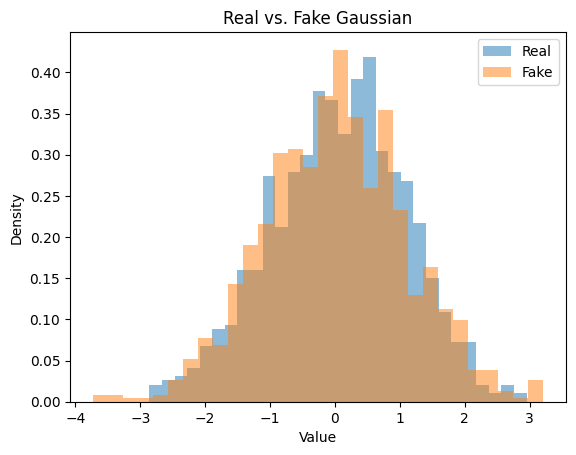

In [51]:
import matplotlib.pyplot as plt


real_viz = real_tensor[:1000].numpy().flatten()

z_viz    = torch.randn(1000, latent_dim)
fake_viz = G(z_viz).detach().numpy().flatten()


plt.hist(real_viz, bins=30, alpha=0.5, density=True, label="Real")
plt.hist(fake_viz, bins=30, alpha=0.5, density=True, label="Fake")
plt.legend()
plt.title("Real vs. Fake Gaussian")
plt.xlabel("Value")
plt.ylabel("Density")
plt.show()


In [52]:
torch.save(G.state_dict(), "generator.pth")
torch.save(D.state_dict(), "discriminator.pth")

## Day 11: Stress-test & Diagnose (Uniform(–1,1))

In [65]:
import numpy as np
real_np = np.random.uniform(low=-1.0,high=1.0,size=(10_000,1))


In [66]:
import torch 
from torch.utils.data import TensorDataset , DataLoader

real_tensor = torch.from_numpy(real_np).float()
dataset = TensorDataset(real_tensor)
loader = DataLoader(dataset,batch_size=16,shuffle=True,drop_last=True)


In [67]:
G = Generator()
D = Discriminator()

import torch.optim as optim
import torch.nn as nn

opt_G    = optim.Adam(G.parameters(), lr=2e-4)
opt_D    = optim.Adam(D.parameters(), lr=2e-4)
criterion = nn.BCELoss()


In [68]:
num_steps , print_every = 2000 , 100
step = 0
losses = {'D':[],'G':[]}

while step < num_steps:
    for (real_batch,) in loader:
        if step >=num_steps:
            break
        bsz = real_batch.size(0)
        real_lables = torch.ones(bsz,1)
        fake_lables = torch.zeros(bsz,1)

        D.zero_grad()
        real_loss = criterion(D(real_batch),real_lables)
        fake_det = G(torch.randn(bsz,100)).detach()
        loss_fake = criterion(D(fake_det),fake_lables)
        loss_D = real_loss + loss_fake
        loss_D.backward()
        opt_D.step()

        G.zero_grad()
        out = D(G(torch.randn(bsz,100)))
        loss_G = criterion(out,real_lables)
        loss_G.backward()
        opt_G.step()

        losses['D'].append(loss_D.item())
        losses['G'].append(loss_G.item())

        if step % print_every == 0:
            print(f"Step {step}/{num_steps}  D-loss: {loss_D:.3f}  G-loss: {loss_G:.3f}")

        step += 1
        


Step 0/2000  D-loss: 1.428  G-loss: 0.782
Step 100/2000  D-loss: 1.405  G-loss: 0.727
Step 200/2000  D-loss: 1.370  G-loss: 0.765
Step 300/2000  D-loss: 1.354  G-loss: 0.727
Step 400/2000  D-loss: 1.377  G-loss: 0.668
Step 500/2000  D-loss: 1.356  G-loss: 0.673
Step 600/2000  D-loss: 1.349  G-loss: 0.671
Step 700/2000  D-loss: 1.363  G-loss: 0.665
Step 800/2000  D-loss: 1.386  G-loss: 0.745
Step 900/2000  D-loss: 1.301  G-loss: 0.827
Step 1000/2000  D-loss: 1.301  G-loss: 0.817
Step 1100/2000  D-loss: 1.488  G-loss: 0.639
Step 1200/2000  D-loss: 1.501  G-loss: 0.614
Step 1300/2000  D-loss: 1.338  G-loss: 0.706
Step 1400/2000  D-loss: 1.222  G-loss: 0.722
Step 1500/2000  D-loss: 1.423  G-loss: 0.662
Step 1600/2000  D-loss: 1.482  G-loss: 0.687
Step 1700/2000  D-loss: 1.433  G-loss: 0.768
Step 1800/2000  D-loss: 1.349  G-loss: 0.848
Step 1900/2000  D-loss: 1.269  G-loss: 0.826


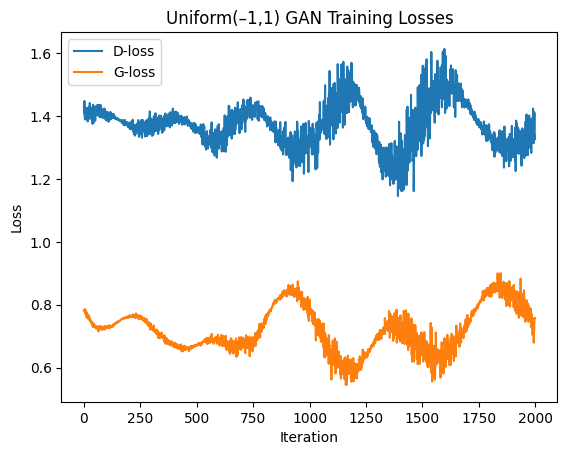

In [69]:

import matplotlib.pyplot as plt

plt.plot(losses['D'], label='D-loss')
plt.plot(losses['G'], label='G-loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Uniform(–1,1) GAN Training Losses')
plt.legend()
plt.show()


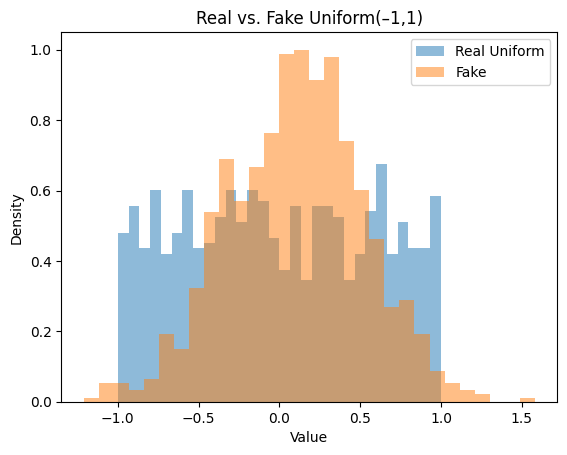

In [70]:

real_viz = real_tensor[:1000].numpy().flatten()
fake_viz = G(torch.randn(1000, 100)).detach().numpy().flatten()

plt.hist(real_viz, bins=30, alpha=0.5, density=True, label='Real Uniform')
plt.hist(fake_viz, bins=30, alpha=0.5, density=True, label='Fake')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Real vs. Fake Uniform(–1,1)')
plt.legend()
plt.show()


### Observations
- **Discriminator performance:**  
  - On the Gaussian data, D-loss dipped as low as ~1.21 (below the random baseline of 1.386), showing it could learn the smooth density differences.  
  - On the Uniform data, D-loss hovered around 1.35–1.45 (near the random baseline), indicating it struggled once G avoided the sharp edges.  

- **Generator behavior:**  
  - Gaussian GAN produced samples covering the full bell curve, with G-loss stabilizing around ~0.7.  
  - Uniform GAN’s fake samples collapsed toward the center ([–0.5, +0.5]), and G-loss oscillated more widely (~0.61–0.83), reflecting mode collapse.  

- **Training stability:**  
  - Gaussian run showed smaller, smoother oscillations in both losses.  
  - Uniform run exhibited larger swings, especially when G briefly ventured into the tails and got penalized.  


### Diagnosis
- **Effect of support shape:**  
  - Gaussian’s smooth, unbounded tails gave no “easy” region to exploit, so D and G reached a tighter equilibrium.  
  - Uniform’s hard cut-offs at ±1 created “danger zones” that D could spot, leading G to collapse into the safer middle region.  

- **Mode collapse trigger:**  
  - Sharp boundaries make the GAN objective unbalanced: G learns to avoid edges where D is strongest, causing sub-interval collapse.  

- **Stability implications:**  
  - Discontinuous support amplifies adversarial oscillations; smooth support yields more stable dynamics.  

- **Next steps:**  
  - Use regularization (e.g., gradient penalty), noise injection at boundaries, or alternative losses (WGAN-GP) to encourage full support coverage.  
  - Experiment with larger latent dimensions or richer generator architectures when the target distribution has hard edges.  
